# Evaluation & Risk Communication
Analysis with **parametric vs bootstrap CIs**, **scenario sensitivity**, and **subgroup checks**.


In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

## Load Data (provided or synthetic fallback)

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np


csv_path = '../data/raw/fraud_kaggle_creditcard_source-kaggle_dataset-creditcardfraud_20250820-192958.csv'

try:
    df = pd.read_csv(csv_path)
except ValueError as e:
    print(f"Error reading CSV: {e}\nRegenerating synthetic data...")
    regenerate = True

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Helper Functions (complete or modify as needed)

In [3]:
def mean_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmean(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

def median_impute(a: np.ndarray) -> np.ndarray:
    m = np.nanmedian(a)
    out = a.copy()
    out[np.isnan(out)] = m
    return out

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), np.array([float(beta[1])])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_[0] * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def bootstrap_metric(y_true, y_pred, fn, n_boot=500, seed=111, alpha=0.05):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    stats = []
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        stats.append(fn(y_true[b], y_pred[b]))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return {'mean': float(np.mean(stats)), 'lo': float(lo), 'hi': float(hi)}

def fit_fn(X, y):
    return SimpleLinReg().fit(X, y)
def pred_fn(model, X):
    return model.predict(X)

## Baseline Fit & Residuals (Required)

In [4]:
X_raw = df['Amount'].values
y = df['Class'].values
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
df['x_imputed'] = X_base
base_mae = mae(y, y_hat)
base_mae

0.00344889345724373

## Parametric vs Bootstrap CI (Required)

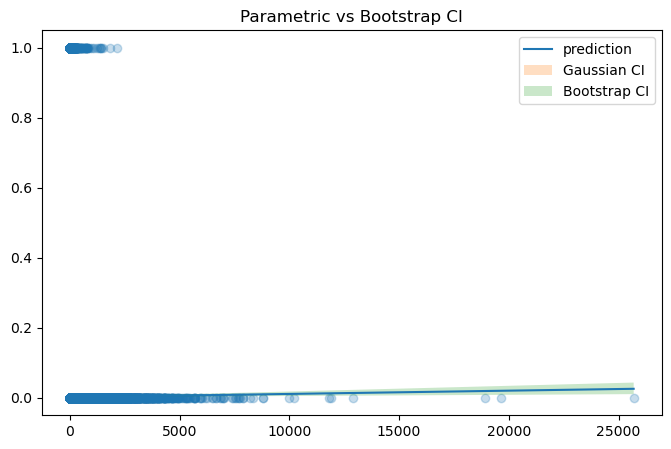

In [5]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25)
plt.plot(x_grid, pred_line, label='prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); 
from matplotlib.pyplot import savefig
savefig('../data/images/Parametric_vs_Bootstrap_CI.png'); plt.show()
plt.show()

## Scenario Sensitivity (Required): Choose ≥2 Scenarios
Examples: mean vs median impute; drop; alternate feature transform

In [6]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,mae,slope,intercept
0,mean_impute,0.003449,9.350343e-07,0.001645
1,median_impute,0.003449,9.350343e-07,0.001645
2,drop_missing,0.003449,9.350343e-07,0.001645


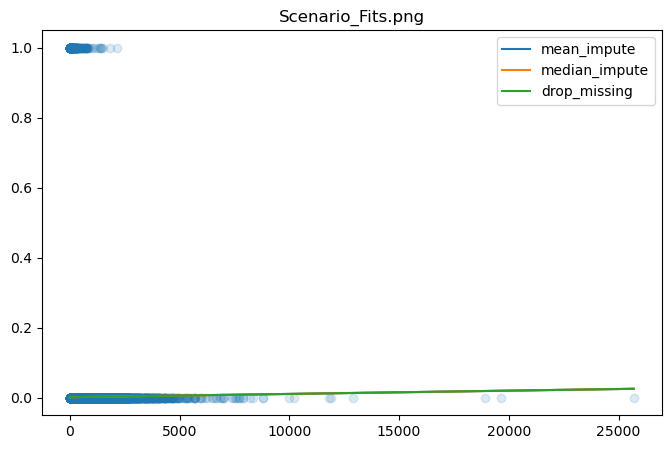

In [7]:
from matplotlib.pyplot import savefig
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(X_base, y, alpha=0.15)
plt.title('Scenario_Fits.png'); plt.legend();
savefig('../data/images/Scenario_Fits.png'); plt.show()

## Subgroup Diagnostic (Required)

In [8]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['Class'] - df2['y_hat']
g = df2.groupby('Class')['Amount'].agg(['mean','std','median','count'])
g

,mean,std,median,count
Class,,,,
0,88.291022,250.105092,22.00,284315
1,122.211321,256.683288,9.25,492


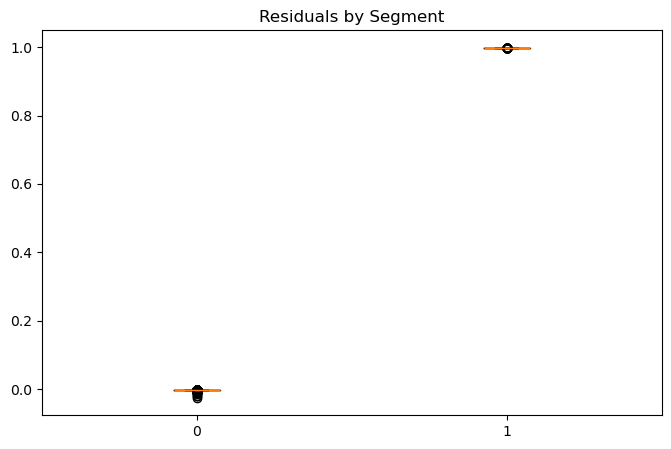

In [9]:
plt.figure()
grouped = df2.groupby('Class')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

plt.boxplot(data, tick_labels=labels)
plt.title('Residuals by Segment')
savefig('../data/images/Residuals_by_Segment.png')
plt.show()


## Bootstrap a Metric (Required)

In [10]:
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
bm

{'mean': 0.003448497032782515,
 'lo': 0.0032945296188701075,
 'hi': 0.003585473551428447}

## Stakeholder Summary (Required — ≤ 1 page)
### Key assumptions for Use/General
- Gaussian CI assumes Normal distribution
- Missing data is random, so replacement techniques do not affect one groups specifically over another
- There is a linear relationship, required for linear regression; verified by the graph and data distribution. 
### Sensitivity results & takeaways
- This CI does not work with the Fraud dataset due to the nonlinear aspect of it, since the data is also for classification only. Therefore the classifier fails to have a good confidence interval accounting for positive fraud detections
- Mean, median and drop-missing are the same - indicates good data quality
### Subgroup risks
- Metrics are really close according to the table
- Judging by the residual per segment, real transactions are spread out more thanthe fraud transactions; 
### “Prediction holds if…”, “Model is sensitive to…”
- The prediction holds if the linear relationship is true; in this case there isn't a linear relationship so that is an issue for the CI analysis. 
### General Assumptions
- Missing Data is particularily random always, huge non random drops would cause risk to groups based on the features the model prioritizes
- The Model is also sensitive to outliers, as seen in the increased range of the bootstrap CI, which indicates that large outliers skew the model. 
- The data needs Homoscedasticity so that predictions are reliable in the same way accross the data; else heteroscedasticity greatly widens the confidence interval and the model will be worse at predicting or classifying. 